In [2]:
# Bibliotecas
import cv2
import numpy as np
import argparse
from config.configClasses import COCO_CLASSES, colors
from yolo.YOLO import yolo
from yolact_detect import yolact
from matplotlib import pyplot as plt

In [3]:
def showYolactResult(srcimg, image, mask_obj, mask_inv):
    srcimg = srcimg[:,:,::-1]
    image = image[:,:,::-1]
    plt.figure(figsize=(10,10))
    
    plt.subplot(141), plt.imshow(srcimg)
    plt.title("01-Imagem Original")

    plt.subplot(142), plt.imshow(image)
    plt.title("02-Objeto Segmentado")

    plt.subplot(143), plt.imshow(mask_obj)
    plt.title("03-Mascara");

    plt.subplot(144), plt.imshow(mask_inv)
    plt.title("04-Mascara Invetida");
    plt.savefig("/home/lucas/Documentos/TCC/Test/Result/G/"+img_easy+"/"+img_easy+"_yolact_process.jpg");

def showObjts(i, objts):
    x = abs(objts[i]["x"] )
    y = abs(objts[i]["y"])

    w = abs(objts[i]["w"])
    h = abs(objts[i]["h"])
    img_raw = image_raw[y:y+h,x:x+w,:]
    
    #  show the imagens;
    plt.subplot(2,len(objts),i), plt.imshow(img_raw[:,:,::-1]);

def showMaskObject(img_ori,  yolo_dect, mask, dilation):
    plt.figure(figsize=(15,10))
    plt.subplot(221), plt.imshow(img_ori[:,:,::-1]);
    plt.title("Imagem original");
    plt.subplot(222), plt.imshow(yolo_dect[:,:,::-1]);
    plt.title("Imagem de saida do YOLO");
    plt.subplot(223), plt.imshow(mask[:,:,::-1]);
    plt.title("Mascara do Bomb");
    plt.subplot(224), plt.imshow(dilation[:,:,::-1])
    plt.title("Mascara dilatada");
    plt.savefig("/home/lucas/Documentos/TCC/Test/Result/G/"+img_easy+"/"+img_easy+"_addMask.jpg");


In [4]:
img_easy="02"
img = cv2.imread("/home/lucas/Documentos/TCC/Test/PHOTOBOMB/Area_grande/"+img_easy+".jpg")
img.shape

(1200, 2400, 3)

In [5]:
def allProcess(img, img_easy):
    yolo_dect, objts, image_raw = yolo(img)

    plt.figure(figsize=(10,10),frameon=False)
    l = len(objts)
    for i in objts.keys():
        showObjts(i=i, objts=objts)
        plt.title("Objeto " + str(i));
    plt.savefig("/home/lucas/Documentos/TCC/Test/Result/G/"+img_easy+"/"+img_easy+"_all_Obj.jpg");

    i = eval(input("Escolha um objeto"))
    x = abs(objts[i]["x"] )
    y = abs(objts[i]["y"])

    w = abs(objts[i]["w"])
    h = abs(objts[i]["h"])
    img_raw = image_raw[y:y+h,x:x+w,:]
    img_ori = image_raw.copy()

    plt.imshow(img_raw[:,:,::-1]);
    plt.title("Objeto escolhido");

In [ ]:
allProcess(img=img, img_easy=img_easy)

## Segmentacao de objeto Yolact

In [6]:
detector = yolact()
srcimg, image, mask_obj, mask_inv =  detector.detect(img_raw, "all",limit_obj=1)

n_white_pix = np.sum(cv2.cvtColor(mask_inv, cv2.COLOR_RGB2GRAY) == 255)
area_maskinv = (n_white_pix*100)/mask_inv.shape[1]*mask_inv.shape[0]
if area_maskinv <= 30:
    mask_inv = mask_obj

showYolactResult(srcimg, image, mask_obj, mask_inv)

NameError: name 'img_raw' is not defined

In [ ]:
image_raw[y:y+h,x:x+w,:] = cv2.bitwise_and(image_raw[y:y+h,x:x+w,:], mask_obj)
image_raw[y:y+h,x:x+w,:] = cv2.bitwise_or(image_raw[y:y+h,x:x+w,:], mask_inv)

mask_ = image_raw.copy()
mask_[:,:,:] = 0
mask_[y:y+h,x:x+w,:] = cv2.bitwise_and(mask_[y:y+h,x:x+w,:], mask_obj)
mask_[y:y+h,x:x+w,:] = cv2.bitwise_or(mask_[y:y+h,x:x+w,:], mask_inv)

In [ ]:
im_mask = img_ori.copy()
im_mask[y:y+h,x:x+w,:] = image

In [ ]:
im_mask = image_raw.copy()
im_mask[y:y+h,x:x+w,:] = image

In [ ]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(mask_,kernel,iterations = 3)

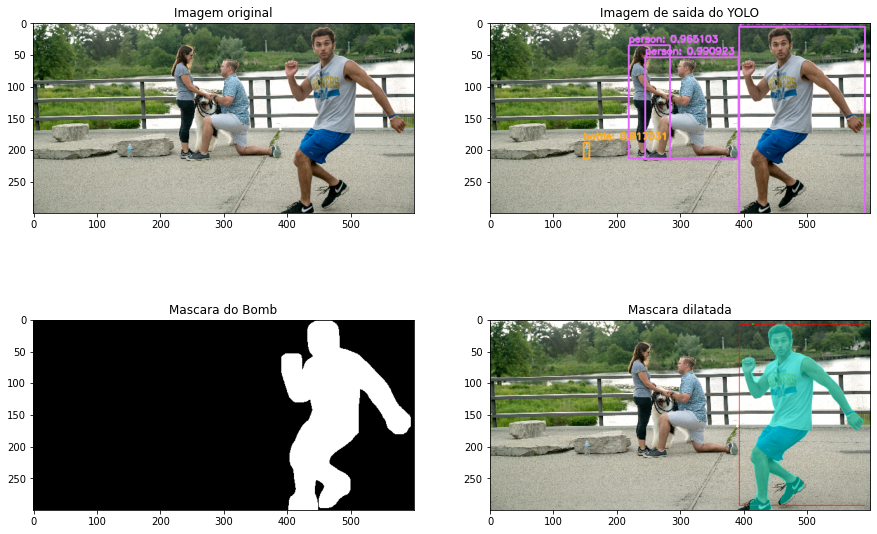

In [ ]:
showMaskObject(img_ori,  yolo_dect, dilation, im_mask)

In [ ]:
# Calculado area do objeto

n_white_pix = np.sum(cv2.cvtColor(mask_, cv2.COLOR_RGB2GRAY) == 255)
print('Area da Segmentacão:', n_white_pix)

area = mask_.shape[0] * mask_.shape[1] 

are_Object = (n_white_pix*100)/area

print(f"{are_Object:.2f}%")

Area da Segmentacão: 19654
10.92%


### Inpainting

In [ ]:
import neuralgym as ng

from inpaint_model import InpaintCAModel

import tensorflow as tf

In [ ]:
FLAGS = ng.Config('inpaint.yml')

model = InpaintCAModel()
image = img_ori.copy()
mask = dilation.copy()
# mask = cv2.imread("generative_inpainting/examples/places2/case6_mask.png")

h, w, _ = image.shape
grid = 8
image = image[:h//grid*grid, :w//grid*grid, :]
mask = mask[:h//grid*grid, :w//grid*grid, :]
print('Shape of image: {} {}'.format(image.shape, mask.shape))

image = np.expand_dims(image, 0)
mask = np.expand_dims(mask, 0)
input_image = np.concatenate([image, mask], axis=2)

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    input_image = tf.constant(input_image, dtype=tf.float32)
    output = model.build_server_graph(FLAGS, input_image)
    output = (output + 1.) * 127.5
    output = tf.reverse(output, [-1])
    output = tf.saturate_cast(output, tf.uint8)
    # load pretrained model
    vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    assign_ops = []
    for var in vars_list:
        vname = var.name
        from_name = vname
        var_value = tf.contrib.framework.load_variable("generative_inpainting/weights", from_name)
        assign_ops.append(tf.assign(var, var_value))
    sess.run(assign_ops)
    print('Model loaded.')
    result = sess.run(output)
    cv2.imwrite("output.png", result[0][:, :, ::-1])
    print("Fim")
tf.reset_default_graph()

---------------------------------- APP CONFIG ----------------------------------
num_gpus_per_job: 1
num_cpus_per_job: 4
num_hosts_per_job: 1
memory_per_job: 32
gpu_type: nvidia-tesla-p100
name: places2_gated_conv_v100
model_restore: 
dataset: celebahq
random_crop: False
val: False
log_dir: logs/full_model_celeba_hq_256
gan: sngan
gan_loss_alpha: 1
gan_with_mask: True
discounted_mask: True
random_seed: False
padding: SAME
train_spe: 4000
max_iters: 100000000
viz_max_out: 10
val_psteps: 2000
data_flist: 
  celebahq: ['data/celeba_hq/train_shuffled.flist', 'data/celeba_hq/validation_static_view.flist']
  celeba: ['data/celeba/train_shuffled.flist', 'data/celeba/validation_static_view.flist']
  places2: ['data/places2/train_shuffled.flist', 'data/places2/validation_static_view.flist']
  imagenet: ['data/imagenet/train_shuffled.flist', 'data/imagenet/validation_static_view.flist']
static_view_size: 30
img_shapes: [256, 256, 3]
height: 128
width: 128
max_delta_height: 32
max_delta_width: 32

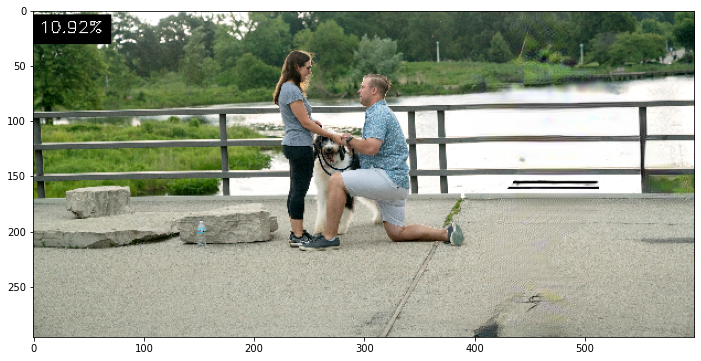

In [ ]:
plt.figure(figsize=(15,6), frameon=False)
cv2.rectangle(result[0], (70, 30), (0, 4), (0,0,0), -1)
cv2.putText(result[0], f"{are_Object:.2f}%", (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
plt.imshow(result[0]);
plt.savefig("/home/lucas/Documentos/TCC/Test/Result/G/"+img_easy+"/"+img_easy+"_result_final.jpg", dpi=720);

In [ ]:
# 1 - Ruim;
# 2 - Razoavel;
# 3 - Bom;
result = input("Sucesso?")
data = open("Test/Result/data.csv","a")
data.write(f"{are_Object:.2f},G," + result + "\n")
data.close()